In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor
sns.set_style("whitegrid")

In [5]:
aggregate=pd.read_csv('./aggregate.csv',engine='python')
aggregate.set_index('GEO_ID',inplace=True)
#Construct extra features for use in the models
aggregate['unemp_bac']=aggregate['unemp_rate']*aggregate['bac_deg']
aggregate['log_pop']=np.log10(aggregate['total_pop'].apply(lambda x: max(x,0.1)))
aggregate['log_urban_pop']=np.log10((aggregate['urban']*aggregate['total_pop']).apply(lambda x: max(x,0.1)))
for x in aggregate.index:
    aggregate.loc[x,'winner'] = 'D' if aggregate.loc[x,'democrat'] > aggregate.loc[x,'republican'] else 'R' #For classifer problems: determine winner in each county


agg_train, agg_test = train_test_split(aggregate,test_size=0.2,shuffle=True,random_state=121) # Split dataset into 80%-20% training and testing, random_state=121 for consistency


features=['white_pc','urban', 'unemp_bac', 'log_pop','log_urban_pop','pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc'] #list of features we want to use
results=['democrat','republican']
target='democrat' #target variable, 'republican'=100-'democrat' approximately

In [114]:
#Do a cross-validation search of hyperparamer space to find the best parameters
xgb=XGBRegressor(max_depth=5,learning_rate=0.1)
test_params = {'n_estimators':range(50,200),'max_depth':[4,5,6],'learning_rate':[0.1,0.15,0.2]}
model=GridSearchCV(estimator=xgb,param_grid=test_params)
model.fit(agg_train[features],agg_train[target])

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=5, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [4, 5, 6],
                         'n_estimators': range(50, 200)})

In [115]:
print(model.best_params_) #parameters for us to use

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 107}


In [4]:
kfold=KFold(n_splits=5,shuffle=True,random_state=121)
mse=0
r2_sc=0
for train_i, test_i in kfold.split(agg_train):
    train_var = agg_train.iloc[train_i]
    test_var = agg_train.iloc[test_i]
    xgb=xgboost.XGBRegressor(n_estimators=model.best_params_['n_estimators'],max_depth=model.best_params_['max_depth'],learning_rate=model.best_params_['learning_rate'])
    #xgb=xgboost.XGBRegressor(n_estimators=107,max_depth=4,learning_rate=0.1)
    xgb.fit(train_var[features].values,train_var['democrat'])
    mse += mean_squared_error(xgb.predict(test_var[features].values), test_var[target])
    r2_sc += r2_score(xgb.predict(test_var[features].values),test_var[target])
mse = mse / 5
r2_sc/=5

In [5]:
print(mse,r2_sc)

67.4240172561023 0.6343785329720125


In [14]:
#Final Run After Model Selection

xgb=xgboost.XGBRegressor(n_estimators=107,max_depth=4,learning_rate=0.1)
xgb.fit(agg_train[features].values,agg_train['democrat'])
pred=xgb.predict(agg_test[features].values)
mse = mean_squared_error(pred, agg_test[target])
r2_sc = r2_score(pred,agg_test[target])

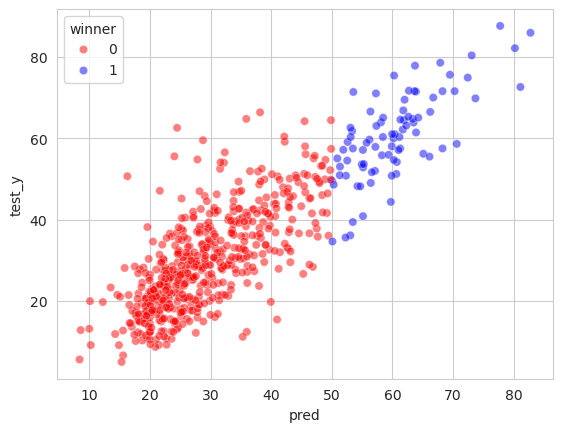

In [15]:
#Example chart
pred=pd.DataFrame({'pred':xgb.predict(agg_test[features].values),'test_y':agg_test['democrat'].values,'winner':agg_test['winner'].values})
for x in pred.index:
    pred.loc[x,'winner'] = 1 if pred.loc[x,'pred'] > 50 else 0
sns.scatterplot(data=pred,x='pred',y='test_y',hue='winner',palette=['red','blue'], alpha=0.5)
plt.show()

In [11]:
np.sqrt(mse)

8.353105419937737

In [10]:
r2_sc

0.6295047913309917